### Quantum Chemistry meets Quantum Computing Tutorial

inspired by: https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html

We want to first define a molecule we want to study, in this example it is a hydrogen molecule, H$_2$, at a distance of 0.7 Angstrom


To install the required packages to run this notebook run:

pip install -r requirements.txt


In [1]:
# Some imports

# pyscf is a handy python-based quantum chemistry software package
from pyscf import gto, scf, lo, tools

# For plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="ticks", context="talk", palette="muted")

# For numerics:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format

# For visualization of molecules and orbitals:
import py3Dmol

# Qiskit related imports and settings
from qiskit_nature.settings import settings
settings.dict_aux_operators = True

# And also import some helper functions from the file helpers/helpers.py
from helpers.helpers import xyz_to_array, run_pyscf_hartfree_fock_calculation, get_h2_geom
from IPython.display import Image


In [2]:
# For test purposes we define a H2 molecule at a distance of 0.7 Angstrom in the so-called .xyz format:
# This describes the molecule and its geometry we want to study. 
# The first number gives the number of atoms in the molecule which is separated from the 
# specific atoms and their position after '***'
h2_xyz = """2
*
H 0.0 0.0 0.0
H 0.0 0.0 0.7
"""

# for Qiskit we need a slightly different format of this geometry
h2_mol = xyz_to_array(h2_xyz)


In [3]:
# We want to quickly visualize this small molecule with the package py3Dmol

viewer = py3Dmol.view(width=400, height=300)
# black outline for nicer-looking figures
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.01})
viewer.addModel(h2_xyz)
# visualize with the stick option - can also consider spheres and more
viewer.setStyle({'stick': {'radius': .2}, 'sphere': {'scale': 0.1}})
# rotate for a better initial view
viewer.rotate(-90, "y")
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The first step in a quantum chemistry is most of the time a 'Hartree-Fock' calculation, which provides the starting point 
for subsequent more accurate calculations and also the quantum computing approach.

In quantum chemistry we map the electronic Hamiltonian on a so-called 'basis set', which is motivated by hydrogen/atom-like orbitals. 
In our case we use a so-called 'minimal basis set' (sto-6g), due to the qubit-number restrictions on current quantum hardware. 

Bigger basis sets would yield more realistic results, but would also exceed the current sizes of available quantum hardware. 
We use the pySCF package to perform these calculations

In [4]:
# this function can also be found in the helpers folder
mf, mol, fci, ci_coeffs = run_pyscf_hartfree_fock_calculation(h2_mol, basis="sto-6g", do_fci=True)

# The atom-like orbitals of the sto-6g basis set resemble hydrogen 1s orbitals, which get combined into a 'bonding' and 
# 'anti-bonding' molecular orbital in the Hartfree Fock procedure. 

# in the Hartfree Fock solution the bonding orbital, which is lower in energy, is occupied by the two electrons of the H2 molecule:
table = pd.DataFrame({"Energy": mf.mo_energy, "Occupancy": mf.mo_occ})
print(table)


   Energy  Occupancy
0  -0.600      2.000
1   0.711      0.000


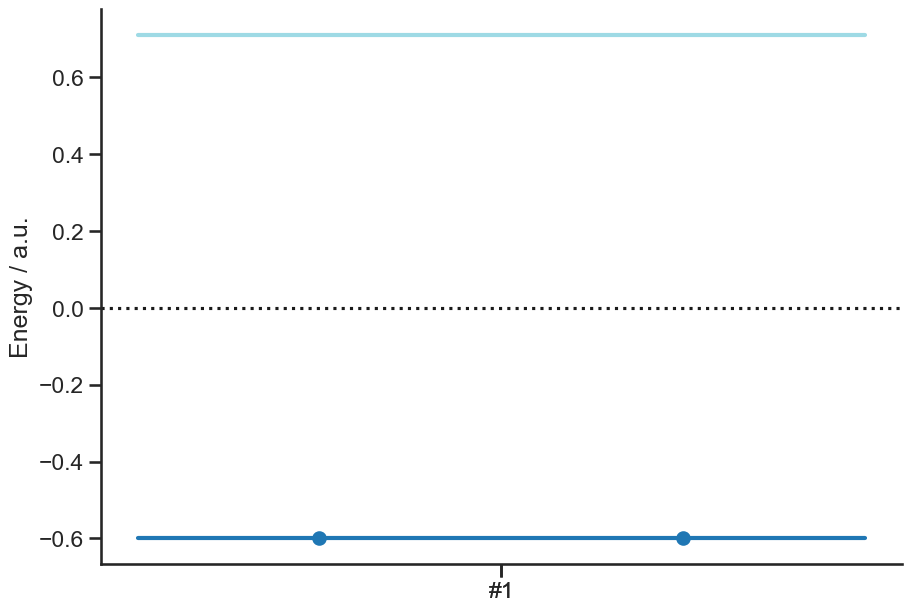

In [5]:
# we can also plot the energy levels:

fig, ax = plt.subplots(constrained_layout=True, figsize=(9, 6))
colors = matplotlib.cm.get_cmap("tab20")(np.linspace(0, 1, len(mf.mo_energy)))

pos = []
for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
    left = 0
    right = 2.5
    length = right - left

    (line,) = ax.plot([left, right], [energy, energy], color=colors[i], lw=3)

    electron_x, electron_y = None, None
    if occ == 2:
        electron_x = [left + 0.25 * length, left + 0.75 * length]
        electron_y = [energy, energy]
    elif occ == 1:
        electron_x, electron_y = [left + 0.5], [energy]
    if electron_x and electron_y:
        ax.scatter(electron_x, electron_y, color=line.get_color())

    pos.append(left + 0.5 * length)

ax.axhline(y=0, ls=":", color="k")
ax.set_xticks(pos)
ax.set_xticklabels([f"#{i}" for i, _ in enumerate(pos)])
ax.set(ylabel="Energy / a.u.")
sns.despine(fig=fig)


## Potential Energy Surface (PES)

In [6]:
dist = np.linspace(0.3,4.0,50)

energy = np.zeros(len(dist))
rhf_energy = np.zeros(len(dist))

for i, r in enumerate(dist):
    h2_mol = xyz_to_array(get_h2_geom(r))
    
    mf, mol, fci_energy, ci_coeffs = run_pyscf_hartfree_fock_calculation(h2_mol, basis="sto-6g", do_fci=True)

    rhf_energy[i] = mf.e_tot
    energy[i] = fci_energy


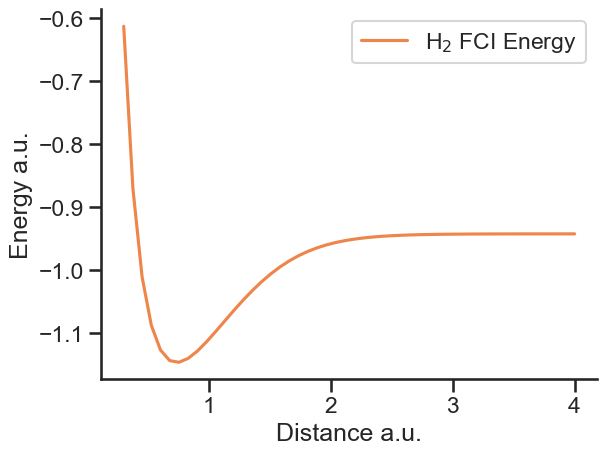

In [7]:
fig, ax = plt.subplots(1)

pal = sns.color_palette()
ax.plot(dist, energy, '-', color=pal[1], label=r'H$_2$ FCI Energy')
ax.legend()
ax.set_xlabel(r'Distance a.u.')
ax.set_ylabel('Energy a.u.')
sns.despine()

fig.savefig('H2-PES.pdf', transparent=True, bbox_inches='tight')
fig.savefig('../slides/figures/H2-PES.pdf', transparent=True, bbox_inches='tight')

# This electronic structure problem, now must be mapped to the quantum computing hardware

<img src="workflow.png" width=1000  />
please see for details:
https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html

In [8]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

# we define the molecule
molecule = Molecule(
    geometry=h2_mol, charge=0, multiplicity=1
)

# and in the language of qiskit an electronic-structure driver, which internally uses PySCF similar what we have done above, 
# with the same geometry and basis set.
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto6g", driver_type=ElectronicStructureDriverType.PYSCF
)




<img src="fermionic-hamil.png" width=1000  />


In [9]:
# following the above mentioned tutorial, this electronic/fermionic problem:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op["ElectronicEnergy"])

Fermionic Operator
register length=4, number terms=36
  -0.6047070702299725 * ( +_0 -_0 )
+ -0.6019506727117674 * ( +_1 -_1 )
+ -0.6047070702299725 * ( +_2 -_2 )
+ -0.6019506727117674 * ( +_3 -_3 )
+ -0.22631134360100727 * ( +_0 +_0 -_0 -_0 )
+ -0.16 ...


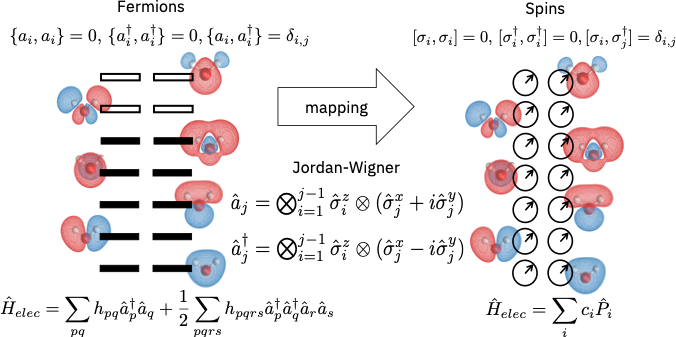

In [10]:
Image('qiskit-jw_mapping.png')

In [11]:
# Needs to be mapped to qubit operators to be executed on quantum hardware

from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op["ElectronicEnergy"])
print(qubit_op)

-0.6868622774170619 * IIII
+ 0.04271316321551506 * IIIZ
+ 0.040820242730677116 * IIZI
+ 0.042713163215515014 * IZII
+ 0.04082024273067706 * ZIII
+ 0.03307289991677634 * IIZZ
+ 0.11315567180050363 * IZIZ
+ 0.0803389002654149 * YYYY
+ 0.0803389002654149 * XXYY
+ 0.0803389002654149 * YYXX
+ 0.0803389002654149 * XXXX
+ 0.11341180018219124 * ZIIZ
+ 0.11341180018219124 * IZZI
+ 0.11367039352623902 * ZIZI
+ 0.03307289991677634 * ZZII


## Ground state calculation
See: https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html

 Now that we have mapped the electroninc structure problem/Hamiltonian of H2 in a sto-6g/minimal basis at 0.7 A separation to a qubit Hamiltonian
 we can calculate its ground state using the Variational Quantum Eigensolver (https://qiskit.org/textbook/ch-applications/vqe-molecules.html)


In [12]:
# To have a reference value we use an exact solver:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

numpy_solver = NumPyMinimumEigensolver()

# which gives us our exact reference result:
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem)

print(res)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.074383512782
  - computed part:      -1.074383512782
~ Nuclear repulsion energy (Hartree): 0.13229430273
> Total ground state energy (Hartree): -0.942089210052
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  7.5589045]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  7.5589045]
    - computed part:      [0.0  0.0  7.5589045]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [13]:
# and now we want to do the same by SIMULATING a quantum computer.
# In this case, as the first step, WITHOUT NOISE, by using the 'aer_simulator_statevector' simulator, which we will change 
# in the future to incorporate the effect of noise

from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))

# UCCFactory is another important ingredient, which defines the type of 'Ansatz' we choose. 
# The UCC (Unitary coupled Cluster) Ansatz is a very accurate, but very expensive ansatz, in the sense that it needs a lot 
# of 1- and 2-qubit gates on quantum hardware. It is essentially only used in simulations without noise, as the current
# hardware is not ready to support it. But for our tutorial here it is fine to use it and get the correct energies.
vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)


calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)
print(res)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.074383442748
  - computed part:      -1.074383442748
~ Nuclear repulsion energy (Hartree): 0.13229430273
> Total ground state energy (Hartree): -0.942089140018
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  7.5589045]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  7.5589045]
    - computed part:      [0.0  0.0  7.5589045]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


/Users/dobrautz/.virtualenvs/cas-project/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dobrautz/.virtualenvs/cas-project/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [27]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.providers.fake_provider import FakeVigo


In [30]:
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', 
                      entanglement_blocks='cx', 
                      reps=1, 
                      entanglement='linear',
                      skip_final_rotation_layer=True)

    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
  
    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=FakeVigo()))
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

print(ansatz)

Optimization complete      
     ┌────────────────────────────────┐
q_0: ┤0                               ├
     │                                │
q_1: ┤1                               ├
     │  TwoLocal(θ[0],θ[1],θ[2],θ[3]) │
q_2: ┤2                               ├
     │                                │
q_3: ┤3                               ├
     └────────────────────────────────┘


In [16]:
from qiskit import QuantumCircuit

c = QuantumCircuit(4)

for i in range(4):
    c.ry(0.0,i)

for i in range(3):
    c.cx(i,np.mod(i+1,4))

c.draw()

┌───────┐               
q_0: ┤ Ry(0) ├──■────────────
     ├───────┤┌─┴─┐          
q_1: ┤ Ry(0) ├┤ X ├──■───────
     ├───────┤└───┘┌─┴─┐     
q_2: ┤ Ry(0) ├─────┤ X ├──■──
     ├───────┤     └───┘┌─┴─┐
q_3: ┤ Ry(0) ├──────────┤ X ├
     └───────┘          └───┘

AttributeError: 'BOPESSamplerResult' object has no attribute 'eigenenergies'

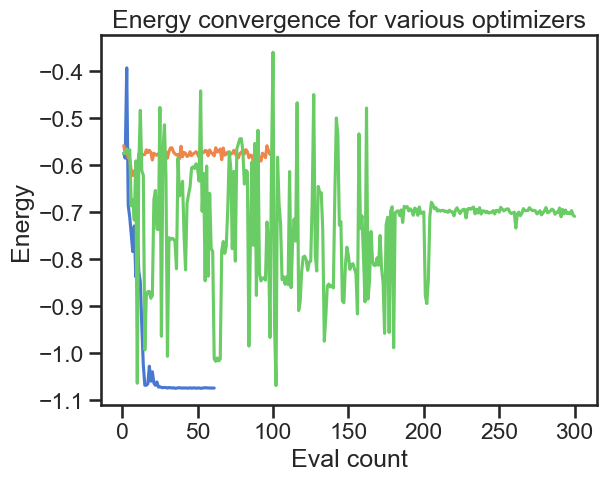

In [25]:
fig, ax = plt.subplots(1)

for i, optimizer in enumerate(optimizers):
    ax.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
ax.set_xlabel('Eval count')
ax.set_ylabel('Energy')
ax.set_title('Energy convergence for various optimizers')
ax.axhline(res.eigenenergies[0], c='k', ls='--', label='Exact')
ax.legend(loc='upper right');


## Optimal Parameters:

In [18]:
for key, value in result.optimal_parameters.items():
    print(key, value)

θ[0] 4.700024974565038
θ[1] 3.1407611326075022
θ[2] 3.156950387718657
θ[3] 3.141776568404448


# Potential energy surfaces
From: https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html

We can now extend this to calculate the ground state energy of H2 as a function of the distance between the H atoms, this is called 
a 'binding cure' or 'potential energy surace'

I will just paste the above example here and maybe you can work through it to get an understanding whats happening

<img src="pes-h2.png" width=1000  />


In [19]:
### From: 
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# qiskit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP

# qiskit nature imports
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.algorithms.pes_samplers import BOPESSampler, Extrapolator

import warnings

warnings.simplefilter("ignore", np.RankWarning)

algorithm_globals.random_seed = 75

In [20]:
es_problem = ElectronicStructureProblem(driver)

qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)

me_gsc = GroundStateEigensolver(qubit_converter, solver)

In [21]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance1],
)

# pass molecule to PSYCF driver
driver = ElectronicStructureMoleculeDriver(mol, driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)

# Specify degree of freedom (points of interest)
points = np.linspace(0.20, 2, 30)
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition
conditions = {False: "no bootstrapping"}#, True: "bootstrapping"}

for value, bootstrap in conditions.items():
    # define instance to sampler
    bs = BOPESSampler(me_gsc, bootstrap=value, num_bootstrap=None, extrapolator=None)
    # execute
    res = bs.sample(es_problem, points)
    results_full[f"{bootstrap}"] = res.raw_results
    results[f"points_{bootstrap}"] = res.points
    results[f"energies_{bootstrap}"] = res.energies

/Users/dobrautz/.virtualenvs/cas-project/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dobrautz/.virtualenvs/cas-project/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Compare to classical eigensolver

In [22]:
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None)
# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

Text(0, 0.5, 'Energy')

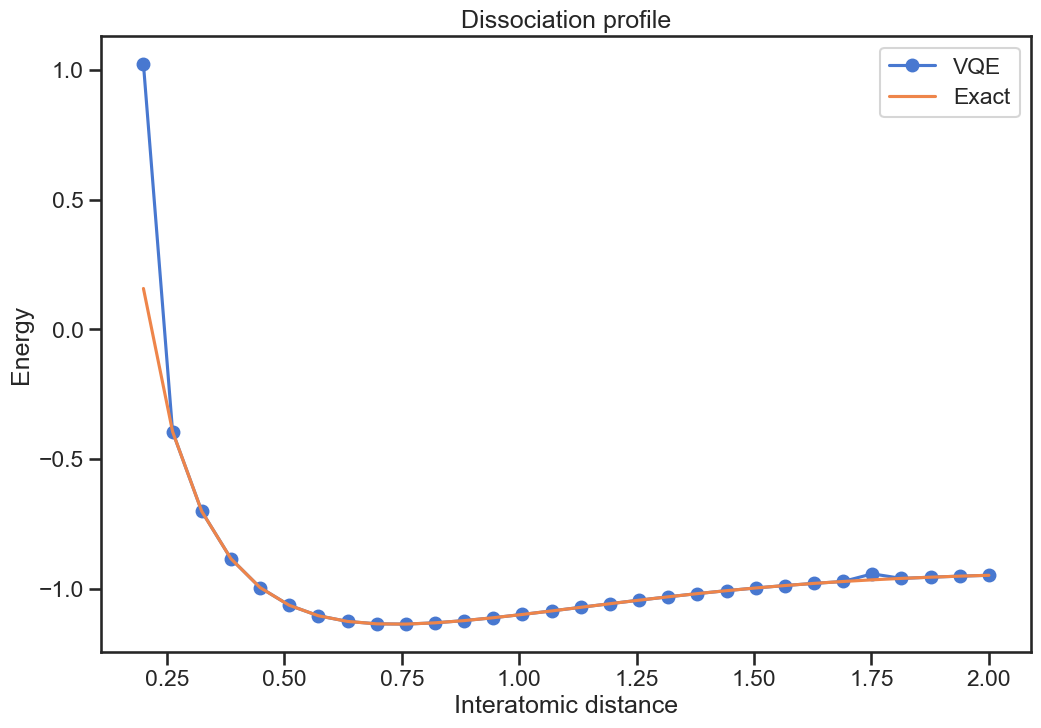

In [23]:
fig = plt.figure(figsize=(12, 8))

for value, bootstrap in conditions.items():
    plt.plot(results[f"points_{bootstrap}"], results[f"energies_{bootstrap}"], '-o', label=f"{bootstrap}")
    
plt.plot(results["points_np"], results["energies_np"], label="numpy")
plt.legend(['VQE','Exact'])
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

## Compare number of evaluations

In [27]:
for condition, result_full in results_full.items():
    print(condition)
    print("Total evaluations for " + condition + ":")
    x = 0
    for key in result_full:
        if condition != "np":
            x += result_full[key].raw_result.cost_function_evals
        else:
            x = 0
    print(x)

no bootstrapping
Total evaluations for no bootstrapping:
19056
bootstrapping
Total evaluations for bootstrapping:
3998
np
Total evaluations for np:
0


In [28]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

## Idea: Work through the general tutorials:
https://qiskit.org/documentation/tutorials.html

and maybe do the tutorials on https://lab.quantum-computing.ibm.com/ (make an account there), then there is everything at one place and all necesseray packages already installed

I would recommend the tutorials:

https://qiskit.org/documentation/tutorials/circuits/index.html

https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html

https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html

https://qiskit.org/documentation/tutorials/circuits_advanced/03_advanced_circuit_visualization.html

https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html

https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

## and especially:
https://qiskit.org/documentation/tutorials/algorithms/01_algorithms_introduction.html

https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html

https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html

https://qiskit.org/documentation/tutorials/algorithms/04_vqe_advanced.html

